In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50
from keras.engine.input_layer import Input
from keras.layers import Dense
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import IsolationForest
from sklearn import svm
from sklearn.metrics import confusion_matrix
from PIL import Image
import numpy as np
import glob
import cv2
import os
from matplotlib import pyplot as plt

path = <Path to dataset folder>
img_height, img_width = 224, 224                               # 224, 224 input size for Resnet50 model
batch_size = 512

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

## Data Loading

In [0]:
filepath = [f for f in os.listdir(path + <'outliers_train'>) if os.path.isfile(os.path.join(path + <'outliers_train'>, f))]
filepath.sort()
filepath

In [0]:
# Loading dataset using traditional cv2 method

X_train1 = []

# Load in the train images
for i, file in enumerate(filepath):
    img = cv2.imread(path + 'train_outlier/car_outlier/{0}'.format(file))
    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    X_train1.append(img)
    if i % 100 == 0:
      print('{} images loaded'.format(i))
    

X_train1 = np.asarray(X_train1)

In [0]:
X_test1 = []

# Load in the test images
for filepath in os.listdir(path + <'outliers_test'>):
    img = cv2.imread(path + 'outliers_test/{0}'.format(filepath))
    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    X_test1.append(img)

X_test1 = np.asarray(X_test1)

In [7]:
print("X_train Shape: ",X_train1.shape)
print("X_test Shape: ",X_test1.shape)

X_train Shape:  (6380, 224, 224, 3)
X_test Shape:  (165, 224, 224, 3)


## Feature Extraction

In [0]:
def extract_resnet(X):  
    # X : images numpy array
    resnet_model = ResNet50(input_shape=(img_height, img_width, 3), weights='imagenet', include_top=False, pooling='avg')
    features_array = resnet_model.predict(X)
    return features_array

In [9]:
X_train = extract_resnet(X_train1)
X_test = extract_resnet(X_test1)
print('feature dimentions', X_train.shape, X_test.shape)

Instructions for updating:
Colocations handled automatically by placer.
94658560/94653016 [==============================] - 1s 0us/step
feature dimentions (6380, 2048) (165, 2048)


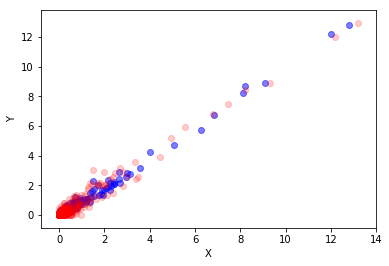

In [10]:
plt.scatter(X_train[0], X_train[1], alpha=0.5, color='b')
plt.scatter(X_test[0], X_test[1], alpha=0.2, color='r')
plt.xlabel('X')
plt.ylabel('Y');

### Normalization

In [11]:
# Apply standard scaler to output from resnet50
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

# Take PCA to reduce feature space dimensionality
pca = PCA(n_components=1024, whiten=True)
pca = pca.fit(X_train)
print('Explained variance percentage = %0.2f' % sum(pca.explained_variance_ratio_))
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

Explained variance percentage = 1.00


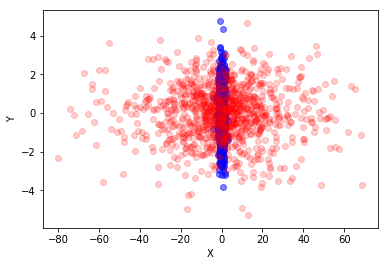

In [12]:
plt.scatter(X_train[0], X_train[1], alpha=0.5, color='b')
plt.scatter(X_test[0], X_test[1], alpha=0.2, color='r')
plt.xlabel('X')
plt.ylabel('Y');

### Create Labels

In [0]:
# Creating hard coded labels

y_good = [-1] * 6000
y_bad = [1] * 380
y_train = y_good + y_bad

y_train = np.asarray(y_train)

y_good = [-1] * 100
y_bad = [1] * 65
y_test = y_good + y_bad

y_test = np.asarray(y_test)

In [0]:
print(y_train.shape)
print(y_test.shape)

(6380,)
(165,)


### Grid Search

In [0]:
OCSVM = {'kernel': ['rbf', poly], 
         'degree': [7, 5], 
         'gamma': [0.1, 0.3, 0.5, 0.7, 0.9, 0.001, 0.005, 0.0001, 0.0009],
         'nu': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

grid = GridSearchCV(estimator=svm.OneClassSVM() , param_grid= OCSVM, scoring='accuracy', cv=cv)
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
       error_score='raise-deprecating',
       estimator=OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto_deprecated',
      kernel='rbf', max_iter=-1, nu=0.5, random_state=None, shrinking=True,
      tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ['rbf'], 'gamma': [0.0009], 'nu': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [0]:
grid.best_estimator_

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.0009, kernel='rbf',
      max_iter=-1, nu=1, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

## Model Fit

In [14]:
# OCSVM
oc_svm_clf = svm.OneClassSVM(kernel='rbf', gamma=0.009, nu=0.15)            # Best = rbf, gamma=0.009, nu=0.15; loss=[93 7, 13 52]

oc_svm_clf.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.009, kernel='rbf',
      max_iter=-1, nu=0.15, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

### Prediction

In [0]:
oc_svm_preds = oc_svm_clf.predict(X_test)

In [21]:
matrix = confusion_matrix(y_test, oc_svm_preds)

print(matrix)
print('True Positives: {} out of 100'.format(matrix[0][0]))
print('True Negatives: {} out of 65'.format(matrix[1][1]))

[[94  6]
 [14 51]]
True Positives: 94 out of 100
True Negatives: 51 out of 65
